# Manuscript Revision

Editor's decision received June 2. No due date given for re-submission.

* [Reviewer 2](#Reviewer-2)
    * [Comment 1](#Comment-1)
    * [Comment 3](#Comment-3)

In [1]:
import bisect

In [2]:
import matplotlib

In [3]:
matplotlib.use('Agg')

In [4]:
%matplotlib inline

In [5]:
import matplotlib.pyplot as plt

In [6]:
import mygene

In [7]:
import os

In [8]:
import pandas as pd

In [9]:
import pickle

---

## Reviewer 2

### Comment 1

* *The sharp drop in AUC observed in Fig. 2a after the top 30 seed sets is a bit surprising. Does this correspond with genes that simply have no edges above the background in the functional network? If that’s the case, I’d suggest excluding these from the analysis due to a lack of data. It’s also a bit surprising that the authors observe no AUCs < 0.5 - given the sampling error on the AUC for small *N*, I would expect some to fall below 0.5 by chance. This is worth a closer look.*

**2016 June 23, July 6, September 29**

To address this, plot AUC against the sum of incident edge weight of the corresponding seed gene. If "the sharp drop in AUC...correspond[s] with genes that simple have no edges above the background", then low incident edge weight should correlate to low AUC. 

In [10]:
organism = 'sapiens'
intactType = 'Phenotypic Enhancement'

In [11]:
os.chdir(os.path.join('..', 'src'))

In [12]:
import func_net_pred

In [22]:
biogridpath, fnetpath = func_net_pred.setup_filepaths(organism)
funcNetDf = pd.read_pickle(fnetpath)
geneExample = funcNetDf.columns[0]
colName = func_net_pred.determine_col(organism, geneExample)
seedSets = func_net_pred.read_biogrid(biogridpath, intactType, colName)
seedAUC, seed2intacts = func_net_pred.seed_set_predictability(funcNetDf, seedSets)

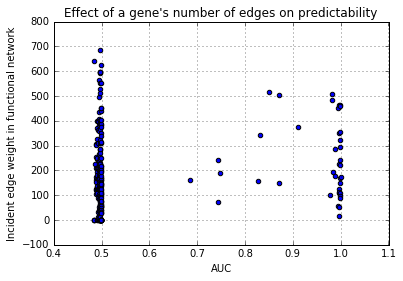

In [14]:
AUCs, seeds = zip(*seedAUC)
seedIncidentWts = funcNetDf.loc[seeds,:].sum(axis=1)
# note that the order of the incident edge weights already corresponds to those 
# of the AUCs due to the zip unpacking
plt.scatter(AUCs, seedIncidentWts)
plt.xlabel('AUC', fontsize='medium')
plt.ylabel('Incident edge weight in functional network', fontsize='medium')
plt.title('Effect of a gene\'s number of edges on predictability', fontsize='large')
plt.tick_params(labelsize='medium')
plt.grid(True)
plt.savefig('SupFig_IncidentEdge.pdf', dpi=300)
plt.show()

**2016 July 11, September 28**

To address why there doesn't appear to be any AUCs &lt; 0.5, first find what the AUCs are that actually fall below 0.5.

In [23]:
AUCs = [t[0] for t in seedAUC]

In [18]:
bisect.bisect(AUCs, 0.5)

199

In [19]:
AUCs[195:202]

[0.49975041597337772,
 0.49977814753189131,
 0.49983361064891846,
 0.49986134220743206,
 0.68478863863308559,
 0.7429688800133134,
 0.74424474399511842]

In [20]:
min(AUCs)

0.48435853347384772

In [19]:
bisect.bisect(AUCs, 0.495)

57

So there are AUCs &lt; 0.5 down to &asymp; 0.48; in fact, there are almost 200 although some of them are close to 0.5 by rounding. 

### Comment 3

*This finding is very surprising to me, and contradicts my own related analyses of that data: “Notably, negative and positive genetic interactions fared poorly as few predictive seed sets were identified, even though most of the experimentally determined interactions in yeast fall into these categories.”* 
    
*If this result is valid, this suggests a deeper issue with the evaluation approach. The yeast data referenced is one of the few datasets where unbiased screens were used to generate the genetic interactions. This may suggest that the good performance observed in other contexts may reflect the biased selection of candidates for screening, not the functional signal of genetic interactions. The extremely high AUCs in the human context are surprising anyway given that there are many unscreened interactions which should look like false negatives to the authors’ classifier, which should dramatically reduce the AUC.* 

*The proper way to evaluate the performance in each context would be to control for the exact set of candidate genes screened in each study and then repeat the measurement of AUC. I realize this isn’t practical for genetic interactions derived from small-scale studies where it isn’t always clear what was actually screened. I'd suggest two directions here to address this concern:*

* **(a)** *The authors should consider exploring the performance on the yeast data if they use a lower AUC cutoffs (<0.9). I suspect they will see non-random performance, but achieving 0.9 AUCs may not be realistic when applied to unbiased data. I suspect the performance estimates are inflated on the non-yeast datasets so non-random but modest AUCs in yeast may be a more realistic estimate of how well the method actually works. Many studies on the yeast genetic interaction network report strong enrichment for functionally related pairs among genes that genetically interact, both using curated and data-derived sources, so there is functional signal in these data. A related point: if the authors are concerned about false positives in the yeast data, many of the published studies actually provide the quantitative genetic interaction scores, which one could threshold at various levels of confidence and see if the conclusion changes for interactions of increasing confidence levels.*

**2016 July 10-11**

A key point of concern is that the results presented in the paper for yeast are contradictory to the literature. The LLS sum method apparently finds poor predictability in the functional network for negative and positive genetic interactions, when by all accounts it should have shown good performance. I suspect that if there indeed is a problem, the source lies at the choice of algorithm itself (the LLS sum) as opposed to other approaches such as GeneMANIA, although the reviewer does not specifically mention this. 

To explore the performance on the yeast data as a function of the AUC cutoff, we could simply plot the proportion of predictive seed sets as a function of the AUC. Evaluate both negative and positive genetic. 

In [15]:
organism = 'cerevisiae'

In [16]:
intactType = 'Negative Genetic'

In [21]:
intactType = 'Positive Genetic'

In [13]:
# code continued from above

In [24]:
totalNumSeeds = len(seedAUC)
proportionSeeds = list()
cutoffAUCs = [i/10 for i in range(1,10)]
for val in cutoffAUCs:
    idxAUCcut = bisect.bisect_left(AUCs, val)
    proportionSeeds.append((totalNumSeeds - idxAUCcut)/totalNumSeeds)

In [20]:
plt.scatter(cutoffAUCs, proportionSeeds, s=30)
plt.ylim(0.0, 1.05)
plt.xlabel('AUC cutoff')
plt.ylabel('Proportion of seed sets meeting AUC cutoff')
plt.title('Yeast {}'.format(intactType))
plt.grid(True)
plt.tight_layout()
plt.savefig('SupFig_neggeneAUCthresh.pdf', dpi=300)
plt.show()

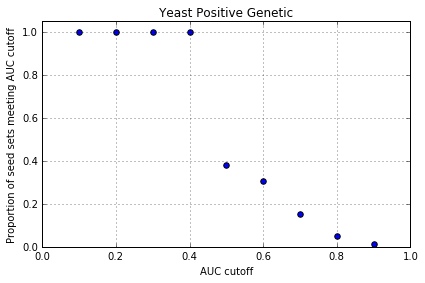

In [25]:
plt.scatter(cutoffAUCs, proportionSeeds, s=30)
plt.ylim(0.0, 1.05)
plt.xlabel('AUC cutoff')
plt.ylabel('Proportion of seed sets meeting AUC cutoff')
plt.title('Yeast {}'.format(intactType))
plt.grid(True)
plt.tight_layout()
plt.savefig('SupFig_posgeneAUCthresh.pdf', dpi=300)
plt.show()

* **(b)** *I suggest the authors pick at least one other context outside of yeast, focus on a single study, establish the proper screening background, and then repeat their AUC analysis, considering only the screening background. This would ideally be done for all datasets but I realize this isn't practical and may be impossible for some. My general concern here is that the reported results send a strong and misleading message: (1) that we are able to predict interactions in higher eukaryotes much better than we actually are, and (2) that the yeast data are fundamentally flawed because the method “doesn’t work” in that setting. The yeast setting is the ideal setting to benchmark a method like this, so if it’s not working there, I suspect the method isn’t working as well as the evaluation metric suggests.*

    Thoughts:  maybe test predictability of human cell-line-specific CRISPR hits?  New data, genome-wide screens, no choice of genetic interaction partners--it’s whatever was mutated in the cell line x whole genome screen.  any predictability supports our case. But may not see it!

    Could also check the non-yeast datasets we already analyzed and see if any are ‘unbiased’ in the same way (e.g. all-by-all screen or cell line x all screen), and what their prediction rate was.

**2016 September 8-10, 16**

First, assemble datasets of CRISPR screens on human cancer cell lines:

* Wang, Tim, et al. "Identification and characterization of essential genes in the human genome." Science 350.6264 (2015): 1096-1101.
* Hart, Traver, et al. "High-resolution CRISPR screens reveal fitness genes and genotype-specific cancer liabilities." Cell 163.6 (2015): 1515-1526.
* Blomen, Vincent A., et al. "Gene essentiality and synthetic lethality in haploid human cells." Science 350.6264 (2015): 1092-1096.
* Sanjana, Neville E. "Genome-scale CRISPR pooled screens." Analytical biochemistry (2016).
* Agrotis, Alexander, and Robin Ketteler. "A new age in functional genomics using CRISPR/Cas9 in arrayed library screening." Frontiers in genetics 6 (2015).

<u>Wang T, et al. *Science* (2015)</u>

Starting off with the Wang et al. paper, the essential genes for 4 cancer cell lines are contained in Supplementary Table S5, which is contained in a PDF document, so the text of the table was copied to a TXT file, *aac7041_SM_TableS5.txt*. Next create a dictionary to map cell line to its specific essential genes. Note that it is the cell line-specific essential genes that are being consider, not all hits. 

In [19]:
aac7041path = os.path.join('..', 'data', 'aac7041_SM_TableS5.txt')

In [20]:
cell2essen = dict()
cellCol = 6
geneCol = 1
for line in open(aac7041path):
    fields = line.split()
    cell2essen.setdefault(fields[6], []).append(fields[1])

In [21]:
cell2essen.keys()

dict_keys(['Jiyoye', 'KBM7', 'Raji', 'K562'])

In [22]:
for cell in cell2essen.keys():
    print( '{}: {:d}'.format(cell, len(cell2essen[cell])) )

Jiyoye: 7
KBM7: 19
Raji: 6
K562: 63


Note that the genes are in symbol format and will need to be converted to Entrez IDs, which is what the human functional net uses.

**2016 September 12-13, 16-17**

Plan to use the *mygene* Python library for the gene ID conversion. 

In [40]:
mg = mygene.MyGeneInfo()

In [15]:
def convert_to_entrez(cellLineDict):
    """Convert gene symbols to Entrez
    INPUT: {'cell line': ['gene sym']}"""
    for cell in cellLineDict.keys():
        entrezIDs = list()
        for genesym in cellLineDict[cell]:
            ans = mg.query('symbol:{}'.format(genesym), species='human')
            for hit in ans['hits']:
                if 'entrezgene' in hit:
                    entrezIDs.append( str(hit['entrezgene']) )
        cellLineDict[cell] = entrezIDs
    return cellLineDict

In [23]:
cell2essen = convert_to_entrez(cell2essen)

In [24]:
# save dictionary in pickle format
aac7041out = os.path.join('..', 'data', 'aac7041essential.pkl')
pickle.dump(cell2essen, open(aac7041out, 'wb'))

<u>Hart T, et al. *Cell* (2015)</u>

**2016 September 13, 15-17**

The Hart et al. study involved CRISPR screens of 5 human cancer cell lines: HCT116, HeLa, GBM, RPE1 &amp; DLD1. From the Supplemental Information, "Each cell line has a different Bayes Factor cutoff at 5% FDR...Genes with BFs above the threshold in the given cell line were considered fitness genes in that cell line. Genes observed in 3 or more of the 5 TKO screens (*n*=1,580) were considered 'core fitness genes' and retained for further analyses." 

The supplemental data files are available at http://tko.ccbr.utoronto.ca. The "Bayes Factors" files and "Fitness Genes" files were downloaded. Assemble a dictionary mapping each cell line to its specific essential genes. 

In [5]:
hartFolder = os.path.join('..', 'data', 'Hart_Cell_CRISPR')

In [6]:
bfThresh = {'HCT116': 1.57, 'HeLa': 15.47, 'GBM': 3.20, 'RPE1': 6.84, 'DLD1': 3.57}

In [7]:
hartline2essen = dict()
for dirpath, dirnames, filenames in os.walk(hartFolder):
    for fname in filenames:
        if 'bayes' in fname:
            cellLine = fname.split('-')[1].split('_')[0]  # ex: bayesfactors-HCT116_2
            bayes = pd.read_table(os.path.join(hartFolder, fname), index_col=0)
            cutoff = bfThresh[cellLine]
            essen = bayes.loc[bayes['BayesFactor'] > cutoff].index.tolist()
            hartline2essen[cellLine] = essen

In [8]:
hartline2essen['HCT116'] = list(set(hartline2essen['HCT116']))

In [9]:
hartline2essen['HCT116'][:5]

['RPS21', 'KIAA1524', 'NUP43', 'SF3B2', 'INTS4']

In [16]:
# convert gene symbols to Entrez IDs
hartline2essen = convert_to_entrez(hartline2essen)

In [17]:
for cell in hartline2essen.keys():
    print( '{}: {:d}'.format(cell, len(hartline2essen[cell])) )

HeLa: 1671
GBM: 2152
RPE1: 1991
DLD1: 1851
HCT116: 2216


In [18]:
# save dictionary in pickle format
hartOut = os.path.join('..', 'data', 'hartEssential.pkl')
pickle.dump(hartline2essen, open(hartOut, 'wb'))

**2016 September 17-18**

As mentioned above, also check whether the non-yeast BIOGRID datasets are all-by-all and therefore "unbiased" using the script *allbyallcheck.py*, i.e.

    python allbyallcheck.py sapiens 'Phenotypic Enhancement'

"Unbiasedness" was determined based on whether the number of gene pairs is equal to the number of possible gene pairs from the list of genes for a given study. Phenotypic enhancement and suppression are examined for both *H. sapiens* and *D. melanogaster*. 

No high-throughput "unbiased" screens were found. The only "unbiased" datasets satisfying the criteria above had a small list of genes, at most 21. 

**2016 September 26**

Adapted *explorenet.py* to create *crisprnet.py* that draws networks for the CRISPR described above. The highest predictive cell line, KBM7, seems worth drawing. Copy code from *Manuscript Figures.ipynb*:

In [5]:
aac7041path = os.path.join('..', 'data', 'aac7041essential.pkl')
aac7041 = pickle.load(open(aac7041path, 'rb'))

In [6]:
fnetpath = os.path.join('..', 'data', 'HumanNetDataFrame.pkl')
funcNetDf = pd.read_pickle(fnetpath)

In [9]:
seedAUC, seed2intacts = func_net_pred.seed_set_predictability(funcNetDf, aac7041)

In [10]:
seedGene = 'KBM7'

In [27]:
llsCut = 3.0

In [44]:
interactors = seed2intacts[seedGene]  # SET SEED GENE BELOW
TF = funcNetDf[interactors] > llsCut
keepPartners = set(TF.index[TF.sum(axis=1) > 1])
useNodes = list(keepPartners) + interactors
finalNet = funcNetDf.loc[useNodes, useNodes].copy()
s = finalNet[finalNet > llsCut].stack()
edgeList = list()
for row in s.iteritems():
    try:
        edgeList.append((mg.getgene(row[0][0])['symbol'], 
            mg.getgene(row[0][1])['symbol'], str(row[1])+'\n'))
    except:
        edgeList.append((row[0][0], row[0][1], str(row[1])+'\n'))

In [46]:
outputPath = os.path.join('..', 'results', 'H_sapiens', 'aac7041_edges.txt')
writefile = open(outputPath, 'w')
writefile.writelines(['\t'.join(edge) for edge in edgeList])
writefile.close()

In [50]:
print([mg.getgene(int(g))['symbol'] for g in interactors])

['KIF18A', 'MCL1', 'ERG', 'CBFB', 'GATA2', 'RBM10', 'SEPSECS', 'RUNX1', 'RAD51B', 'RAD51D', 'TRAF2', 'LIAS', 'STAT5B', 'RTEL1', 'BCL2', 'FANCM', 'LIPT2']


Edge list imported into Cytoscape and duplicate edges were removed. Attributes were set as described in *Manuscript Figures.ipynb*, except:

* Border Width Bypass &rarr; 2.0
* Height &rarr; 35.0
* Image/Chart Position 1 &rarr; North (Node Anchor Points)
* Label Font Size &rarr; 16
* Width &rarr; 75.0